# GSoC 2023 ML4SCI QML-HEP Tasks

Marçal Comajoan Cara

## Task VII: Equivariant Quantum Neural Networks


### Task Statement

In this task you are supposed to get started with equivariant quantum neural networks by implementing a $\mathbb{Z}_2 \times \mathbb{Z}_2$ equivariant quantum neural network. $\mathbb{Z}_2$ is a symmetry group and as an example we will generate a simple classical dataset which respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry.
This example is explained in the paper "Exploiting symmetry in variational quantum machine learning" [1] and additional background can be found in "Theory for Equivariant Quantum Neural Networks" [2]. 
- Generate a classification dataset with two classes and two features $x_1$ and $x_2$ which respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry (this corresponds to mirroring along $y=x$). An example can be found in the first reference paper.
- Train a QNN to solve the classification problem
- Train an $\mathbb{Z}_2 \times \mathbb{Z}_2$ equivariant QNN to solve the classification problem and compare the results.

---

### Introduction

In this notebook, we explore the implementation of a $\mathbb{Z}_2 \times \mathbb{Z}_2$ equivariant quantum neural network (QNN) and compare its performance with a non-equivariant QNN for a binary classification problem. The dataset for this task is generated such that it respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry. We use PennyLane [3] and PyTorch [4] for building and training the QNNs. We also use matplotlib [5] to visualize the dataset generated.


In [1]:
import torch
import torch.nn as nn
import pennylane as qml
import matplotlib.pyplot as plt

### Dataset generation

We generate a classification dataset with two classes and two features $x_1$ and $x_2$ which respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry, which corresponds to mirroring along $y=x$. Specifically, random numbers between -5 and 5 are generated for both features, and each class is assigned according to the regions of the space that are separated by the function $y=1/x$ (see figure below). Then data is standardized, and the training and testing sets are created, with 1000 and 100 samples each, respectively.

In [2]:
def generate_dataset(n):
    x = (torch.rand((n, 2)) - 0.5) * 10
    y = ((x[:,0] < 0) & (x[:,1] < 1/x[:,0])) | ((x[:,0] > 0) & (x[:,1] > 1/x[:,0]))  # 1 if (x1 < 0 and x2 < 1/x1) or (x1 > 0 and x2 > 1/x1), 0 otherwise
    x[:, 0] = (x[:,0] - torch.mean(x[:,0])) / torch.std(x[:,0])
    x[:, 1] = (x[:,1] - torch.mean(x[:,1])) / torch.std(x[:,1])
    return x, y

x_train, y_train = generate_dataset(1000)
x_test, y_test = generate_dataset(100)

Let us see how it looks:

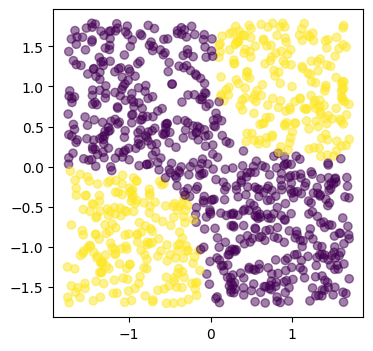

In [3]:
plt.figure(figsize=(4, 4))
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, alpha=0.5);

Finally, we create the PyTorch datasets and data loaders. We use a batch size of 100.

In [4]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

### Common training code

We define functions for computing accuracy and loss (criterion) as well as the training process. These functions will be used for both the non-equivariant and equivariant QNNs.

For the loss, we use the mean square error between the expected output of the QNN, which is one, and the actual output of the QNN. The expected output is always one because in the QNN we will be measuring the fidelity between the target label and the state of the circuit. The fidelity, in this context, is a measure of similarity between the predicted quantum state and the target quantum state. When the fidelity is high (closer to 1), it indicates that the predicted state is very similar to the target state, and therefore, the classification is more accurate. By minimizing the mean square error in the loss function, the QNN is trained to maximize the fidelity between the predicted and target states, which in turn should improve the classification performance.

In [5]:
def accuracy(qnn, weights, set_x, set_y, labels_dm):
    preds = []
    for x in set_x:
        probs = torch.tensor([qnn(weights, x, label_dm).detach() for label_dm in labels_dm])
        preds.append(torch.argmax(probs).item())
    return (torch.tensor(preds) == set_y).sum().item() / len(set_y)

def criterion(qnn, weights, batch_x, batch_y, labels_dm):
    # Compute the mean squared error
    loss = 0
    for x, y in zip(batch_x, batch_y):
        out = qnn(weights, x, labels_dm[y.to(int)])
        loss += (1 - out)**2
    return loss / len(batch_y)

def train(qnn, weights, labels_dm, optimizer, n_epochs):
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")

        # Train the model
        for batch_x, batch_y in train_dataloader:
            # Compute the loss and gradients
            loss = criterion(qnn, weights, batch_x, batch_y, labels_dm)
            loss.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad()

        # Print the accuracies
        print(f' TRAINING\tAccuracy: {accuracy(qnn, weights, x_train, y_train, labels_dm):.6f}')
        print(f" TESTING \tAccuracy: {accuracy(qnn, weights, x_test, y_test, labels_dm):.6f}")

We also create the quantum device to construct the PennyLane QNodes to run the quantum circuits that define the QNNs. We will define circuits that have 2 qubits, as we will use angle embedding to encode the two features of the dataset.

In [6]:
dev = qml.device("default.qubit.torch", wires=2)

### Non-equivariant quantum neural network

Now we define the non-equivariant QNN. I decided to keep it really simple by only performing an angle embedding of the two features on the two qubits, followed by the strongly entangling layers provided by PennyLane ([`qml.StronglyEntanglingLayers`](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)), and a measurement on q0. `qml.StronglyEntanglingLayers` is actually a template to generate layers consisting of single qubit rotations and entanglers with CNOTs. The number of layers is determined by the given weight tensor, which must have $(L, M, 3)$, where $L$ is the number of layers, and $M$ the number of wires.

At the output of the cell, we can see the circuit diagram:

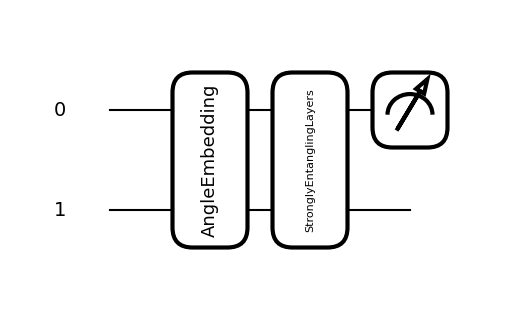

In [7]:
@qml.qnode(dev, interface="torch")
def non_equivariant_qnn(w, x, y):
    qml.AngleEmbedding(x, wires=[0, 1])
    qml.StronglyEntanglingLayers(w, wires=[0, 1])
    return qml.expval(qml.Hermitian(y, wires=[0]))
    
fig, ax = qml.draw_mpl(non_equivariant_qnn)(torch.zeros(2, 2, 3), torch.zeros(2), torch.zeros(2, 2))

Next we define the state label for each class and generate their density matrices. These will be used to get the described fidelity when measuring the expectation of the Hermitian.

In [8]:
state_label_0 = torch.tensor([[1], [0]])
state_label_1 = torch.tensor([[0], [1]])
state_labels = [state_label_0, state_label_1]
non_equivariant_labels_dm = torch.stack([s * torch.conj(s).T for s in state_labels])

non_equivariant_labels_dm

tensor([[[1, 0],
         [0, 0]],

        [[0, 0],
         [0, 1]]])

Finally, let us train the QNN. We will use a single layer, resulting in $1\cdot 2\cdot 3=6$ parameters to train. We use the Adam optimizer with a learning rate of 0.1 and train for 5 epochs.

In [9]:
non_equivariant_weights = torch.randn(1, 2, 3, requires_grad=True)
non_equivariant_optimizer = torch.optim.Adam([non_equivariant_weights], lr=0.1)

train(non_equivariant_qnn, non_equivariant_weights, non_equivariant_labels_dm, non_equivariant_optimizer, 5)

Epoch 0
 TRAINING	Accuracy: 0.592000
 TESTING 	Accuracy: 0.620000
Epoch 1
 TRAINING	Accuracy: 0.592000
 TESTING 	Accuracy: 0.660000
Epoch 2
 TRAINING	Accuracy: 0.585000
 TESTING 	Accuracy: 0.680000
Epoch 3
 TRAINING	Accuracy: 0.593000
 TESTING 	Accuracy: 0.650000
Epoch 4
 TRAINING	Accuracy: 0.593000
 TESTING 	Accuracy: 0.610000


We can see that the QNN learns to classify the data, but not very good. It only attains an accuracy of 68% on the test set (in epoch 2).

Of course, we can use many parameters to create a more deep and powerful QNN. For example, next we define another non-equivariant QNN with two strongly entangling layers instead of one, resulting in 12 trainable paramerters.

In [10]:
non_equivariant_weights = torch.randn(2, 2, 3, requires_grad=True)
non_equivariant_optimizer = torch.optim.Adam([non_equivariant_weights], lr=0.1)

train(non_equivariant_qnn, non_equivariant_weights, non_equivariant_labels_dm, non_equivariant_optimizer, 5)

Epoch 0
 TRAINING	Accuracy: 0.781000
 TESTING 	Accuracy: 0.860000
Epoch 1
 TRAINING	Accuracy: 0.960000
 TESTING 	Accuracy: 0.970000
Epoch 2
 TRAINING	Accuracy: 0.904000
 TESTING 	Accuracy: 0.940000
Epoch 3
 TRAINING	Accuracy: 0.954000
 TESTING 	Accuracy: 0.990000
Epoch 4
 TRAINING	Accuracy: 0.937000
 TESTING 	Accuracy: 0.970000


This time the QNN learns almost perfectly how to classify the data, obtaining an accuracy of 99% on the test set!

However, could we achieve similar results by using a more wise architecture with less parameters?

### Equivariant Quantum Neural Network

Now we define an equivariant QNN that respects the $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry. The equivariant QNN architecture consists of angle embedding of the two features, followed by RX gates and RZZ gates. The RX gates are applied to each qubit separately, while the RZZ gates are applied between the two qubits to entangle them. Each of these gates has a trainable parameter, resulting in a QNN that only has 4 parameters, which is less than both the non-equivariant QNN defined before.

The choice of the gates that can be used to respect this symmetry is discussed in [1]. The circuit is also designed in such a way that it remains invariant under the transformations of the symmetry group, thus hopefully leading to a more efficient learning process. 

At the output of the cell, we can see the circuit diagram:

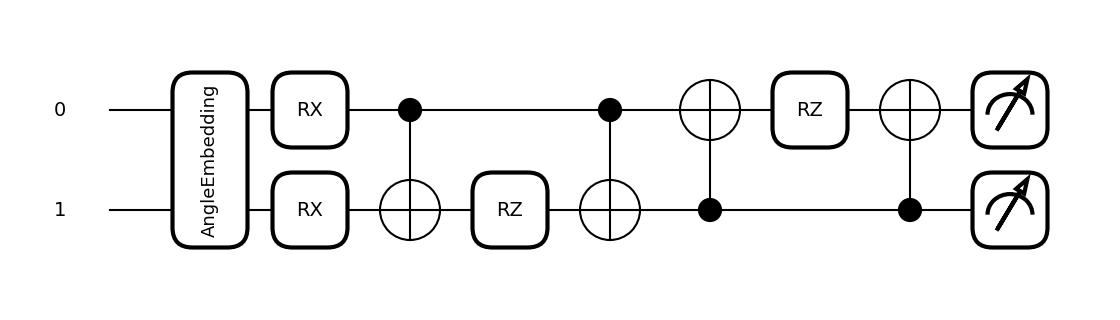

In [11]:
@qml.qnode(dev, interface="torch")
def equivariant_qnn(w, x, y):
    qml.AngleEmbedding(x, wires=[0, 1])

    # RX gates
    qml.RX(w[0], wires=[0])
    
    qml.RX(w[1], wires=[1])

    
    # RZZ gates
    qml.CNOT(wires=[0, 1])
    qml.RZ(w[2], wires=[1])
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[1, 0])
    qml.RZ(w[3], wires=[0])
    qml.CNOT(wires=[1, 0])
    
    
    return qml.expval(qml.Hermitian(y, wires=[0, 1]))
    
fig, ax = qml.draw_mpl(equivariant_qnn)(torch.zeros(4), torch.zeros(2), torch.zeros(4, 4))

Next, we define the state labels for each class and generate the density matrices accordingly to create be able to train the equivariant QNN. Now the observables must be invariant under SWAP and Pauli-X gates.

In [12]:
state_label_0 = torch.tensor([[1],  [1],  [1], [1]]) / 2
state_label_1 = torch.tensor([[1], [-1], [-1], [1]]) / 2
state_labels = [state_label_0, state_label_1]
equivariant_labels_dm = torch.stack([s * torch.conj(s).T for s in state_labels])

equivariant_labels_dm

tensor([[[ 0.2500,  0.2500,  0.2500,  0.2500],
         [ 0.2500,  0.2500,  0.2500,  0.2500],
         [ 0.2500,  0.2500,  0.2500,  0.2500],
         [ 0.2500,  0.2500,  0.2500,  0.2500]],

        [[ 0.2500, -0.2500, -0.2500,  0.2500],
         [-0.2500,  0.2500,  0.2500, -0.2500],
         [-0.2500,  0.2500,  0.2500, -0.2500],
         [ 0.2500, -0.2500, -0.2500,  0.2500]]])

Finally, we train the equivariant QNN using the Adam optimizer with a learning rate of 0.1 and for 5 epochs.

In [13]:
equivariant_weights = torch.randn(4, requires_grad=True)
equivariant_optimizer = torch.optim.Adam([equivariant_weights], lr=0.1)

train(equivariant_qnn, equivariant_weights, equivariant_labels_dm, equivariant_optimizer, 5)

Epoch 0
 TRAINING	Accuracy: 0.867000
 TESTING 	Accuracy: 0.880000
Epoch 1
 TRAINING	Accuracy: 0.873000
 TESTING 	Accuracy: 0.890000
Epoch 2
 TRAINING	Accuracy: 0.873000
 TESTING 	Accuracy: 0.890000
Epoch 3
 TRAINING	Accuracy: 0.872000
 TESTING 	Accuracy: 0.890000
Epoch 4
 TRAINING	Accuracy: 0.872000
 TESTING 	Accuracy: 0.890000


As we can observe, the equivariant QNN performs much better than the simple non-equivariant QNN, achieving an accuracy of 89% on the test set compared to the 68% of the simple non-equivariant QNN. Moreover, the equivariant QNN used 2 parameters less. This demonstrates the effectiveness of leveraging the symmetry present in the problem to design more efficient and accurate QNNs.

### References

1. [Johannes Jakob Meyer et al. Exploiting symmetry in variational quantum machine learning (2022)](https://arxiv.org/abs/2205.06217)
2. [Quynh T. Nguyen et al. Theory for Equivariant Quantum Neural Networks (2022)](https://arxiv.org/abs/2210.08566)
3. [PennyLane](https://pennylane.ai/)
4. [PyTorch](https://pytorch.org)
5. [matplotlib](https://matplotlib.org/)